In [18]:
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from keras.layers import LSTM, Dense,Flatten
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from os.path import exists
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from sklearn.metrics import roc_auc_score


In [2]:
#df_failures=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_failures.csv")
#df_machines=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_machines.csv")
#df_telemetry=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_telemetry.csv")

#df_failures.to_csv('equipment_failures.csv')
#df_machines.to_csv('equipment_machines.csv')
#df_telemetry.to_csv('equipment_telemetry.csv')

In [59]:
df_failures=pd.read_csv('equipment_failures.csv')
df_machines=pd.read_csv('equipment_machines.csv')
df_telemetry=pd.read_csv('equipment_telemetry.csv')

In [60]:
df=pd.merge(df_failures,df_machines, on="machineID")
df=pd.merge(df,df_telemetry,on="machineID")
#df=df.sort_values(by="datetime_x")


Discover what the data looks like for the first 100 transactions


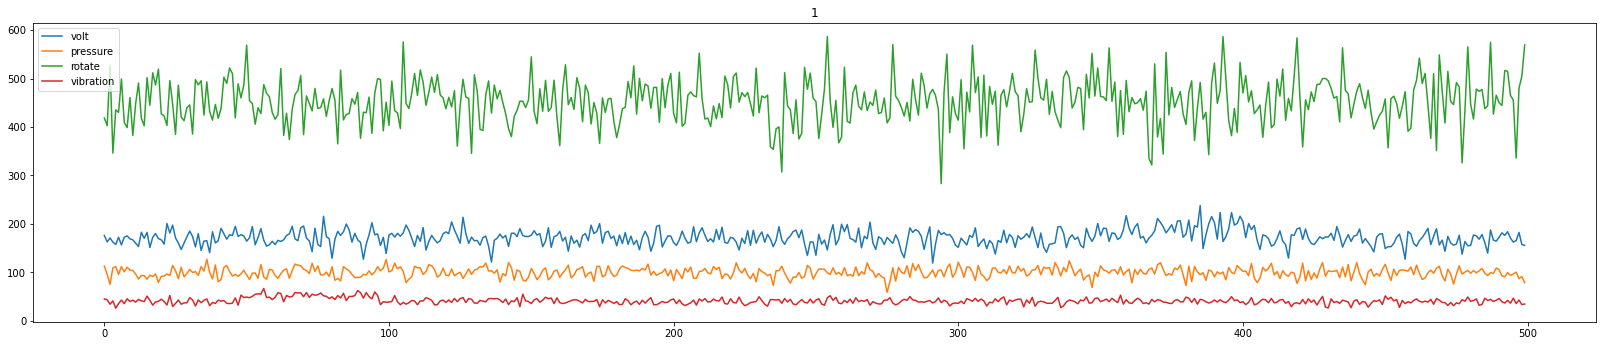

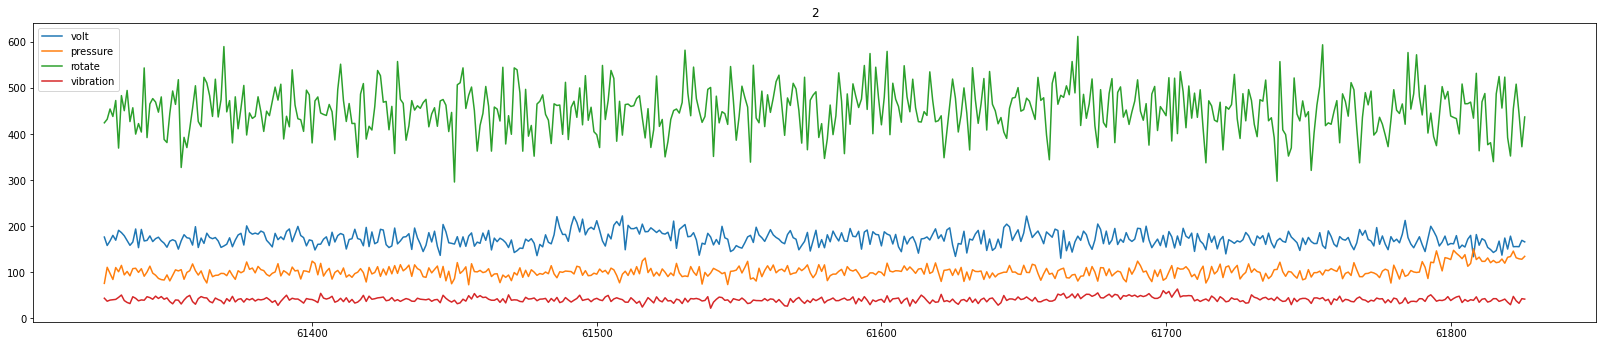

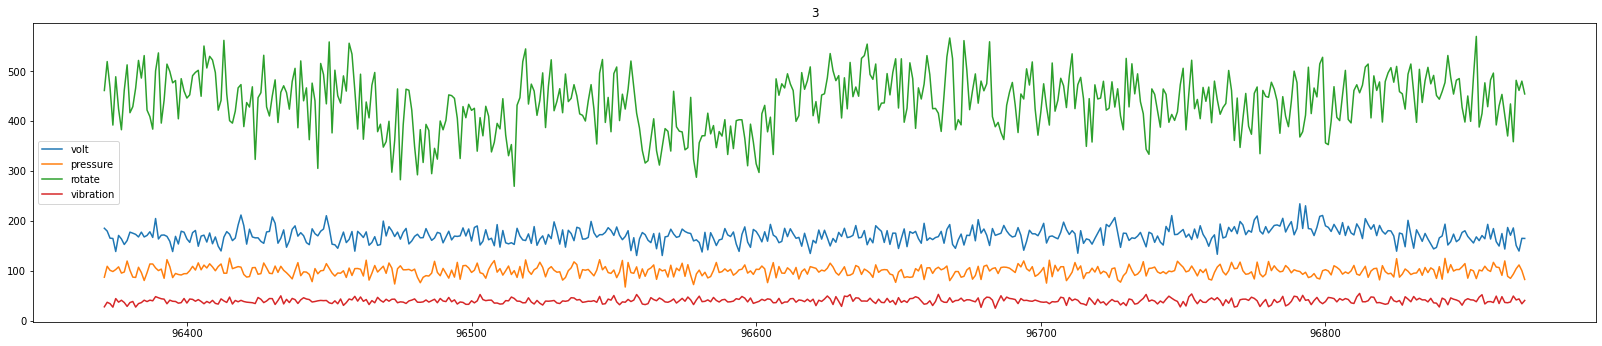

In [61]:
#'machineID', 'label', 'model', 'age', 'volt', 'rotate', 'pressure'
print("Discover what the data looks like for the first 100 transactions")
machineIds=[]
grouped=df.groupby('machineID')
for machineID in grouped:
    machineIds.append(machineID[0])

#print(machineIds)
plt.rcParams["figure.figsize"] = (28,5.5)
for machineId in machineIds[0:3]:
    #print(machineId)
    filter=df['machineID']==machineId
    results=df[filter][:500]
    #print(len(results))
    #print(results['datetime_x'])
    x=range(0,len(results)-1,1)
    plt.plot(results['volt'],label='volt')
    plt.plot(results['pressure'],label='pressure')
    plt.plot(results['rotate'],label='rotate')
    plt.plot(results['vibration'],label='vibration')
    #twin_ax=plt.twinx()
    #twin_ax.plot(results['age'],label='age')
    plt.title(machineId)
    plt.legend()
    plt.show()
    



In [62]:
print("Drop non contributing features and dummy the multi-class output")
if "datetime_x" in df:
    df.drop(["Unnamed: 0","Unnamed: 0_x","Unnamed: 0_y","datetime_y","datetime_x","age"],axis=1,inplace=True)
    df.rename(columns={"failure":"label"},inplace=True)

failure_types=set(df['label'])
print(failure_types)

encoder=LabelEncoder()
df['label']=encoder.fit_transform(df['label'])
df['model']=encoder.fit_transform(df['model'])

X_columns=[x for x in df.columns if x!='label']

X=df[X_columns]
y=df['label']
#y = np.asarray(y).astype(np.float32)
y = pd.get_dummies(y)

print(y)

print(df.columns)
print(df.head(1))

Drop non contributing features and dummy the multi-class output
{'comp2', 'comp1', 'comp4', 'comp3'}
         0  1  2  3
0        0  0  0  1
1        0  0  0  1
2        0  0  0  1
3        0  0  0  1
4        0  0  0  1
...     .. .. .. ..
6667116  0  1  0  0
6667117  0  1  0  0
6667118  0  1  0  0
6667119  0  1  0  0
6667120  0  1  0  0

[6667121 rows x 4 columns]
Index(['machineID', 'label', 'model', 'volt', 'rotate', 'pressure',
       'vibration'],
      dtype='object')
   machineID  label  model        volt      rotate    pressure  vibration
0          1      3      2  176.217853  418.504078  113.077935  45.087686


In [38]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

print(X_train.columns)
print("rows",X_train.shape[0],"columns",X_train.shape[1])
print((X_train.shape[0],X_train.shape[1],1))

Index(['machineID', 'model', 'volt', 'rotate', 'pressure', 'vibration'], dtype='object')
rows 4466971 columns 6
(4466971, 6, 1)


In [8]:
print("build the LSTM model")
look_back=1
model = Sequential()
features=len(X_columns)
model.add(LSTM(units=550, activation='tanh', return_sequences=True, input_shape=(look_back, features),dtype="float32"))
model.add(Dropout(0.2))
model.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(len(y_train.columns),activation='softmax'))
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

build the LSTM model


In [9]:
print("X train shape",X_train.shape)
#print(X_train)
print("y train shape",y_train.shape)


X train shape (4466971, 6)
y train shape (4466971, 4)


In [46]:
def plotHistory(history):
        plt.plot(history.history['accuracy'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
print ("Train the model")
length=len(X_train)
path_to_file="C:\\Users\\dnishimoto\\python_files\\python-deep-learning-master\\lstm_equipment_model.h5"

batch_size=1000
start_pos=65000
look_back=1

for index in range(start_pos,length,batch_size):
    if(index>0):
        file_exists = exists(path_to_file)
        if(file_exists):
            model.load_weights(path_to_file)
            print("loaded weights")
        print(index-batch_size,index)
        X2 = np.asarray(X_train[index-batch_size:index]).astype(np.float32)
        X2 = np.resize(X2,(X2.shape[0],look_back,X2.shape[1]))
        y2 = np.asarray(y_train[index-batch_size:index]).astype(np.float32)
        history=model.fit(X2,y2,batch_size=len(X),epochs=500,verbose=0)
        model.save_weights(path_to_file) # can give whole path to save model
        print("saved weights")
        plotHistory(history)

Train the model
loaded weights
64000 65000


KeyboardInterrupt: 

In [67]:
print("Random select indices from the dataframe then make a prediction")
size=len(df)
randomlist=[]
for i in range(0,10):
    n = random.randint(1,size)
    randomlist.append(n)
#print(randomlist)

look_back=1
X3=df[X_columns].iloc[randomlist]
y3=df['label'].iloc[randomlist]
y3 = pd.get_dummies(y3)

X3 = np.asarray(X3).astype(np.float32)
X3 = np.resize(X3,(X3.shape[0],look_back,X3.shape[1]))
y_pred=model.predict(X3)

#lstfailure_types=next(iter(failure_types))
for item in y_pred:
    print("failure type",np.argmax(item))

auc=roc_auc_score(y3, y_pred)
print(auc)


Random select indices from the dataframe then make a prediction
1/1 [==============================] - 0s 16ms/step


TypeError: must be str, not numpy.int64

In [31]:
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 550)            1225400   
                                                                 
 dropout (Dropout)           (None, 1, 550)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            260400    
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 flatten (Flatten)           (None, 50)                0

In [ ]:
 auc=roc_auc_score(y, predictions)